###  Введение

В ходе исследования мы загрузим данные (тексты песен) при помощи парсинга сайта, проведем обработку текстов, а также проанализируем тексты на совпадения. Так же  в ходе нашего анализа мы  протестируем тексты на схожесть при помощи модели  скрытого семантического индексирования текстов (LSI). По итогу будет создано облако из наиболее часто встречающихся слов в текстах.

In [ ]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np
import nltk 
from nltk.tokenize import word_tokenize, sent_tokenize, wordpunct_tokenize
# from nltk.stem.snowball import SnowballStemmer # стеммер - преобразует тексты к начальной форме
from nltk.corpus import stopwords
nltk.download('all')
nltk.download('punkt')
nltk.download('stopwords')
from pymystem3 import Mystem
from wordcloud import WordCloud
from gensim.similarities import Similarity
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### Напишем небольшую функцию- парсер для загрузки текстов песен
Будем загружать с сайта https://txt-pesen.ru тексты песен 3-х известных исполнителей: Ария, Би-2 и Наутилус Помпилиус.

In [2]:
def parser(url):
    
    response = requests.get(url, params='')
    soup = bs(response.content, 'html.parser')
    text = ''
    songs = soup.find_all('tr', class_ = 'cat-list-row0')

    for i in songs:
        page = i.find('td', class_="list-title").find('a').get('href') 
        url = 'https://txt-pesen.ru/' + str(page)
        response = requests.get(url, params='')
        soup = bs(response.content, 'html.parser')
        if (soup.find('div',itemprop="articleBody")) == None: # пропуск пустых страниц
            continue
        song = soup.find('div',itemprop="articleBody").get_text()
        song = song[:-70]
        text = text + song
    return text

        # with open('nautilus.csv', 'w') as file: # для сохранения в файл
        #     file.write(nautilus)
        
url_1 = 'https://txt-pesen.ru/russkij-rok/nautiluspompilius.html' 
url_2 = 'https://txt-pesen.ru/russkij-rok/arija.html' 
url_3 = 'https://txt-pesen.ru/russkij-rok/bi2.html' 

# url = input('Скопируйте и вставьте адрес с главной страницы исполнителя') # вариант для самостоятельного выбора пользователем
            
nautilus = parser(url_1)
aria = parser(url_2)
bdva = parser(url_3)

In [3]:
len(aria) # проверим  длину загруженной строки

67074

In [4]:
aria[-210:-1] # проверим, что загрузили на примере  группы Ария. Все верно - песня точно их;)

'\n\r\nЯ - свободен, словно птица в небесах.\r\nЯ - свободен! Я забыл, что значит страх.\r\nЯ - свободен, с диким ветром - наравне.\r\nЯ - свободен, наяву, а не во сне.\n\r\nЯ - свободен!\r\nЯ - свободен!\r\nЯ - свободен! \n\n\n\n'

#### Обработка  текста будет происходить при помощи функции, которая  принимает на вход текст и возвращает леммы токенов предложения, фильтруя по стоп-словам и удаляя знаки пунктуации.

In [5]:
# для удаления знаков пунктуации
import string
punctuations = list(string.punctuation)

In [6]:
# set нужен для того, чтобы поиск по словам был быстрее
from nltk.corpus import stopwords
ru_stop_words = set(stopwords.words('russian'))

In [7]:
# к данному списку можно добавлять свои слова,  мешающие работе алгоритма 
stopwords_list = stopwords.words('russian')
my_stop_words = ['я','тебе','поэтому', 'припев', 'это','куплет', 'Ты','твой','...','пикник','ария','наутилус','помпилиус','песня','мой','твой', 'наш','нам ','мы:']
stopwords_list.extend(my_stop_words)

In [8]:
#  Данная функция принимает на вход текст и возвращает леммы токенов предложения, фильтруя по стоп-словам и удаляя знаки пунктуации
def text_processing(text, stopwords, punct):
    text = text.lower()
    words = wordpunct_tokenize(text) # С помощью токенизации разбиваем текст на токены 
    words = [word for word in words if word not in punct] # Удаляем знаки пунктуации
    words = [word for word in words if word not in stopwords] # Удаляем стопслова
    new_text = ','.join(words)
    mystem = Mystem()
    new_text = mystem.lemmatize(new_text) # лемматизируем текст
    return new_text

In [9]:
nautilus_lemm_text = text_processing(nautilus, stopwords_list, punctuations)
aria_lemm_text = text_processing(aria, stopwords_list, punctuations)
bdva_lemm_text = text_processing(bdva, stopwords_list, punctuations)

Проверим результат работы функции сравним длину текста до и после обработки

In [10]:
len(nautilus)

53147

In [11]:
len(nautilus_lemm_text)

11012

Как видно  функция работает - количество лишних знаков в тексте уменьшилось в 5 раз.

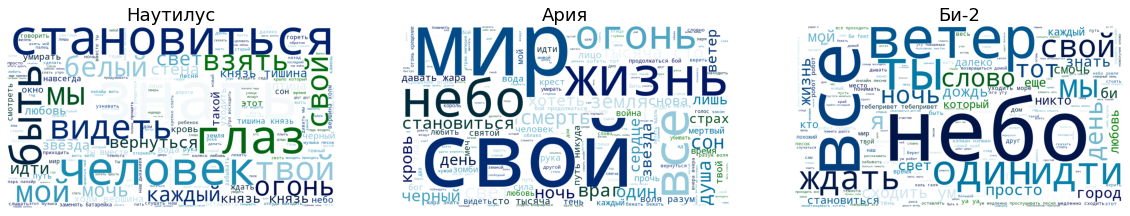

In [12]:
# посторим облаков из слов по текстам каждого исполнителя:
texts_list = [nautilus_lemm_text, aria_lemm_text, bdva_lemm_text]
all_singers = ['Наутилус','Ария', 'Би-2']
i = 1
for name, text in zip(all_singers, texts_list):
    plt.rcParams['figure.figsize'] = (20,15)
    text_raw = " ".join(text)
    wordcloud = WordCloud(colormap='ocean', background_color='white',height =500, width = 900).generate(text_raw)
    plt.subplot(1, 3, i, label=name,frame_on=True)
    plt.tick_params(labelsize=10)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(name,fontdict={'fontsize':18,'color':'black'},y=1)
    plt.tick_params(labelsize=10)
    i += 1

Теперь посмотрим насколько отличаются тексты у данных исполнителей, для этого импортируем библиотеку difflib

In [13]:
import difflib

texts_list = [nautilus_lemm_text, aria_lemm_text, bdva_lemm_text]
all_singers = ['Наутилус','Ария', 'Би-2']

def similarity(text1, text2):

  matcher = difflib.SequenceMatcher(None, text1, text2)
  return matcher.ratio()

for i in range(0, len(texts_list)):
    for j in range(i+1, len(texts_list)):
        if i != j:
            print('Совпадение текстов', all_singers[i], '-',all_singers[j], (similarity(texts_list[i], texts_list[j]))*100, '%')

Совпадение текстов Наутилус - Ария 0.8622016936104695 %
Совпадение текстов Наутилус - Би-2 0.6842833224139186 %
Совпадение текстов Ария - Би-2 0.5154311167674197 %


Совпадение у текстов незначительное - тексты не воруют у друг друга:)

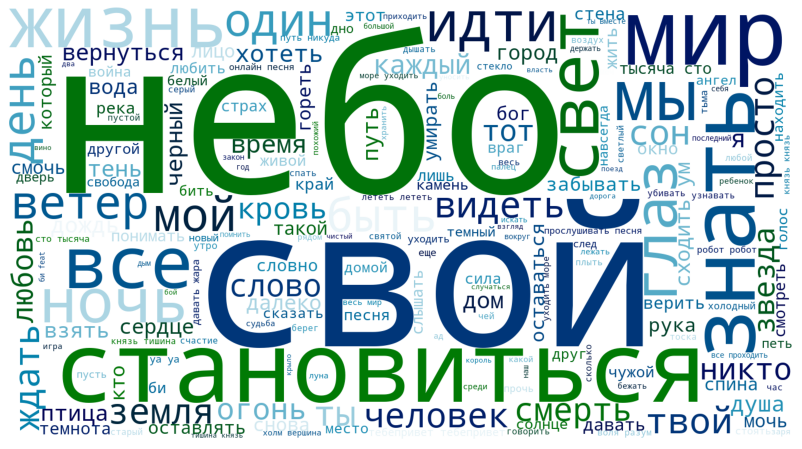

In [14]:
# Объединим данные всех исполнителей для определения наиболее часто встречающихся слов
# Построим облако слов из наиболее часто встречающихся слов у данных исполнителей:
plt.rcParams['figure.figsize'] = (16,8)
text_raw = " ".join(nautilus_lemm_text) + " ".join(aria_lemm_text) + " ".join(bdva_lemm_text)
wordcloud = WordCloud(colormap='ocean', background_color='white',height =800,
                      width = 1450).generate(text_raw)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 2. Создание тематической модели с LSI.

Следующим шагом в ходе нашего анализа будет проведение схожести текстов  при помощи модели  скрытого семантического индексирования текстов (LSI) от Gensim.

Gensim – это библиотека с открытым исходным кодом на Python, написанная Радимом Рехуреком, которая используется для тематического моделирования без учителя и обработки естественного языка (NLP). Она предназначена для извлечения семантических тем из документов.

Подробнее:
https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html#sphx-glr-auto-examples-core-run-core-concepts-py

Для начала обработки текста нужно этот самый текст получить - будем снова парсить:)
Парсинг данных с  сайта www.darklyrics.com.

In [15]:
url = 'http://www.darklyrics.com/m/metallica.html' # страница, с корторой парсим информацию

# для начала получим название каждого из альбома для прохода в цикле

response = requests.get(url, params='')
soup = bs(response.content, 'html.parser')
text = ''
album = soup.find_all(class_ = 'album')

for i in album:
    page = i.find('a').get('href')
    text = text + page[20:] + ','  
albums = text.split(sep = ',' )

In [16]:
albums = ['killemall.html#1', 'ridethelightning.html#1', 'masterofpuppets.html#1', 'garagedaysrevisited.html#1', 'andjusticeforall.html#1', 'metallicablackalbum.html#1', 'load.html#1', 'reload.html#1', 'garageinc.html#1', 'stanger.html#1', 'deathmagnetic.html#1', 'hardwiredtoselfdestruct.html#1', '72seasons.html#1']

In [17]:
# почистим название альбомов
albums_ = ['kill em all.html#1', 'ride the lightning.html#1', 'master of puppets.html#1', 'garage days revisited.html#1', 'and justice for all.html#1', 'metallica black album.html#1', 'load.html#1', 'reload.html#1', 'garage inc.html#1', 'stanger.html#1', 'death magnetic.html#1', 'hardwired to selfdestruct.html#1', '72 seasons.html#1']
albums_clean = []
for i in range (0,len(albums_)):
    albums_clean.append(albums_[i][:-7])

In [18]:
albums_clean

['kill em all',
 'ride the lightning',
 'master of puppets',
 'garage days revisited',
 'and justice for all',
 'metallica black album',
 'load',
 'reload',
 'garage inc',
 'stanger',
 'death magnetic',
 'hardwired to selfdestruct',
 '72 seasons']

In [19]:
# основной код для парсера
album  = ''
#  список для лемматизации текста
list_albums = [] 

for i in range(0,len(albums)):
    url = 'http://www.darklyrics.com/lyrics/metallica/' + str(albums[i])
    response = requests.get(url, params='')
    soup = bs(response.content, 'html.parser')
    texts = soup.find('div',class_="lyrics").get_text()
#     studio_albums.append(str(albums[i])[:-7]) 
    album = album + albums[i][:-7] +  texts + ',,,'
    list_albums.append(texts)

In [20]:
documents = album.split(sep = ',,,') # создадим список для создания корпуса
documents =  documents[:-1]

In [21]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [22]:
#  создание корпуса и словаря

from collections import defaultdict
from gensim import corpora

# удаление слов из стоп-листа и токенезация
stoplist = set('for a of the and to in  james hetfield lars ulrich metallica lyrics cliff burton mustaine'.split())
texts = [
    [word for word in document.lower().split() if word not in stoplist]
    for document in documents
]

# удаление слов, которые повторяются только 1 раз
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

2023-04-29 18:24:28,713 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-04-29 18:24:28,724 : INFO : built Dictionary<2389 unique tokens: ['#3', '#4', '#6', '#7', '#9']...> from 13 documents (total 28300 corpus positions)
2023-04-29 18:24:28,733 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<2389 unique tokens: ['#3', '#4', '#6', '#7', '#9']...> from 13 documents (total 28300 corpus positions)", 'datetime': '2023-04-29T18:24:28.733147', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}


In [23]:
from gensim import models # импортируем модель 
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=2)

2023-04-29 18:24:28,765 : INFO : using serial LSI version on this node
2023-04-29 18:24:28,765 : INFO : updating model with new documents
2023-04-29 18:24:28,772 : INFO : preparing a new chunk of documents
2023-04-29 18:24:28,776 : INFO : using 100 extra samples and 2 power iterations
2023-04-29 18:24:28,778 : INFO : 1st phase: constructing (2389, 102) action matrix
2023-04-29 18:24:28,779 : INFO : orthonormalizing (2389, 102) action matrix
2023-04-29 18:24:28,815 : INFO : 2nd phase: running dense svd on (102, 13) matrix
2023-04-29 18:24:28,823 : INFO : computing the final decomposition
2023-04-29 18:24:28,823 : INFO : keeping 2 factors (discarding 19.022% of energy spectrum)
2023-04-29 18:24:28,823 : INFO : processed documents up to #13
2023-04-29 18:24:28,823 : INFO : topic #0(644.060): 0.489*"i" + 0.455*"you" + 0.271*"my" + 0.240*"your" + 0.223*"me" + 0.219*"it" + 0.150*"is" + 0.131*"on" + 0.125*"all" + 0.125*"so"
2023-04-29 18:24:28,823 : INFO : topic #1(167.026): 0.422*"my" + -0.3

In [ ]:
# данная функция сравнивает вектор текста(альбома)  со словарем, созданным из корпуса слов - на выходе мы получаем список словарей с результатами схожести текстов

from gensim.similarities import Similarity
from gensim.test.utils import common_corpus, common_dictionary, get_tmpfile

list_sims = []

def vec_bow(doc):
    ************************************* 
    sims = sorted(enumerate(similarities))
    for doc_position, doc_score in sims:
        album1 = doc.split(sep='\n')
        album2 = documents[doc_position].split(sep='\n')
        if str(album1[0]) == str(album2[0]):
            doc_score = 0
        matrix[album2[0]] = doc_score
    return(matrix)

for i in range(0,len(documents)):
    list_sims.append(vec_bow(documents[i]))

In [25]:
# создадим датафрейм для более удобной работы по анализу текстов
df_albums_sims = pd.DataFrame(list_sims, index=albums_clean)

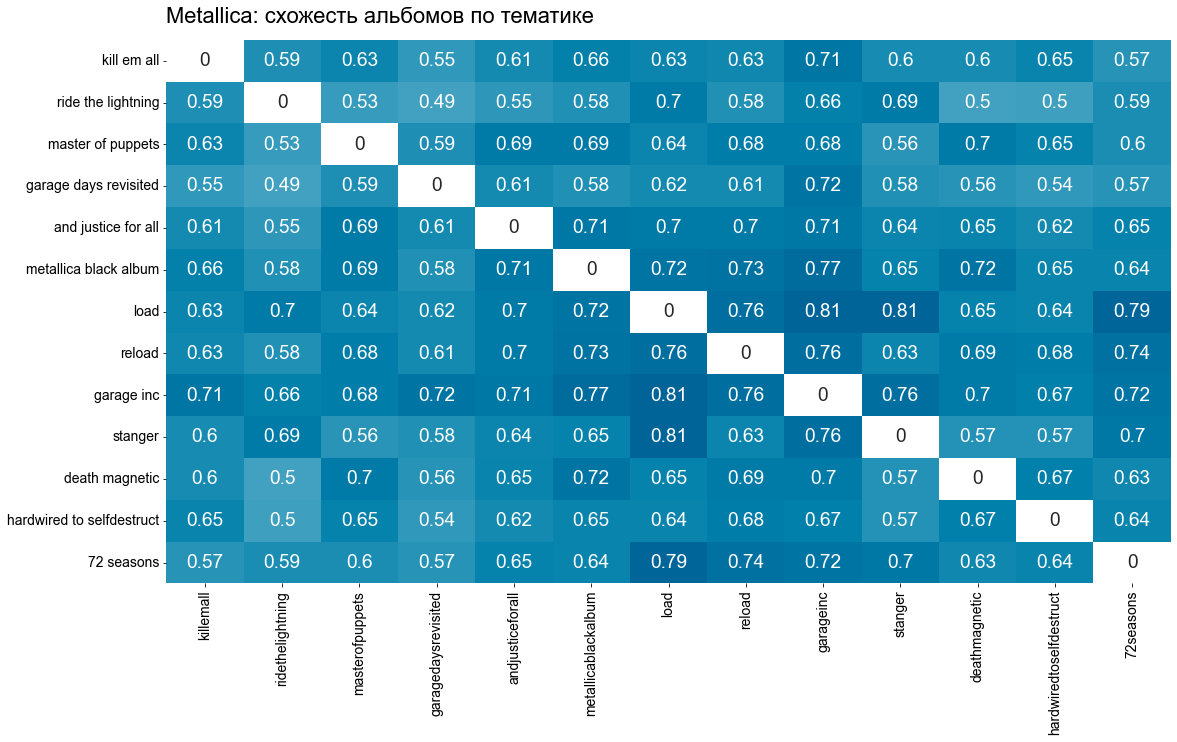

In [26]:
# на основе датафрейма построим тепловую карту 
fig, ax = plt.subplots(figsize=(18,10))
sns.set(font_scale=1.6)
sns.heatmap(df_albums_sims, center=1, annot=True,cmap='ocean_r',cbar=False, alpha=1)
ax.set_title('Metallica: схожесть альбомов по тематике',loc='left',fontsize=22, y=1.02)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

Альбомы расположены в хронологическом порядке их выхода и на тепловой карте мы чётко видим: альбомы начиная с 'and justice for all' по  'stanger' (на середине творческого пути группы), а также последний на  2023 год альбом "72 seasons" имеют наиболее сильную (0,7 и более) схожесть по тематике.


In [27]:
# найдем  пары альбомов с наиболее сильной схожестью
top_sims = {}
for index, row in df_albums_sims.items():
#     print('Схожесть',  round(row.max(),2),'%', ':', index, ' - ',row.idxmax())
    top_sims[round(row.max(),3)] =  str(index) +  ' / '+  str(row.idxmax())

#  создадим и отсортируем датафрейм
top_sims_df = pd.DataFrame(top_sims.keys(), index=top_sims.values(),columns=['Sims'])
top_sims_df_sort = top_sims_df.sort_values(by = 'Sims', ascending=True)

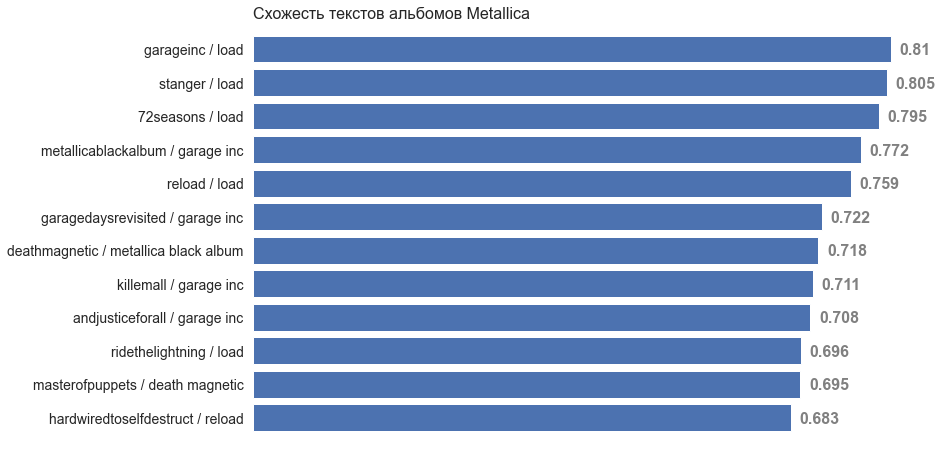

In [28]:
# построим диаграмму barh
sns.set_theme(style="whitegrid")
labels = top_sims_df_sort.index
data = top_sims_df_sort['Sims']
fig, ax = plt.subplots(figsize=(12,8))  
plt.barh(labels, data,  height=0.8, color='b') 
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.yticks(fontsize = 14)
plt.xticks([])
ax.set_title('Схожесть текстов альбомов Metallica',fontsize = 16,loc='left', y=0.98)
for i, v in enumerate(data):
    ax.text(v + 0.011 , i - 0.16 , str(v), color='grey', fontsize = 16, fontweight='bold')
plt.show()

In [29]:
# для построения облака слов из альбомов выполним:

# для удаления знаков пунктуации
import string
punctuations = list(string.punctuation)
# set нужен для того, чтобы поиск по словам был быстрее
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')
stoplist = set('solo yeah oh for a of the and to in  james hetfield lars ulrich metellica lyrics cliff burton mustaine verse chorus deluxe bonus edition track riff ... . :] " , '.split())
stopwords_list.extend(stoplist)

In [30]:
#  Данная функция принимает на вход текст и возвращает леммы токенов предложения, фильтруя по стоп-словам и удаляя знаки пунктуации
def text_processing(text, stopwords, punct):
    text = text.lower()
    words = wordpunct_tokenize(text) # С помощью токенизации разбиваем текст на токены 
    words = [word for word in words if word not in punct] # Удаляем знаки пунктуации
    words = [word for word in words if word not in stopwords] # Удаляем стопслова
    new_text = ','.join(words)
    mystem = Mystem()
    new_text = mystem.lemmatize(new_text) # лемматизируем текст
    return new_text

In [31]:
# пропустим список обработанных альбомов через данную функцию
metallica_lemm_text_list = []
for i in range (0, len(list_albums)):
    metallica_lemm_text_list.append(text_processing(list_albums[i], stopwords_list, punctuations))

In [32]:
# топ слов из самых похожих альбомов (Схожесть 0.81 % : load  -  garageinc)
theLowerFreqs = nltk.FreqDist(metallica_lemm_text_list[6])
theLowerFreqs.tabulate(10)
theLowerFreqs = nltk.FreqDist(metallica_lemm_text_list[8])
a = theLowerFreqs.tabulate(10)

    ,   way  take   let waste  hear   day  time never     . 
 1699    30    30    23    22    21    19    19    18    18 
    ,  time   see   die gonna never  hell gotta  know  make 
 3090    48    43    37    33    32    32    29    29    27 


In [33]:
# посчитаем количество слов в альбоме
count_word_in_album = {}
for i in range (0, len(list_albums)):
         count_word_in_album[len(list_albums[i])] = albums_clean[i]
count_word_in_album

#  создадим и отсортируем датафрейм
count_word_df = pd.DataFrame(count_word_in_album.keys(), index=count_word_in_album.values(),columns=['word_count'])
count_word_df = count_word_df.sort_values(by = 'word_count', ascending=True)

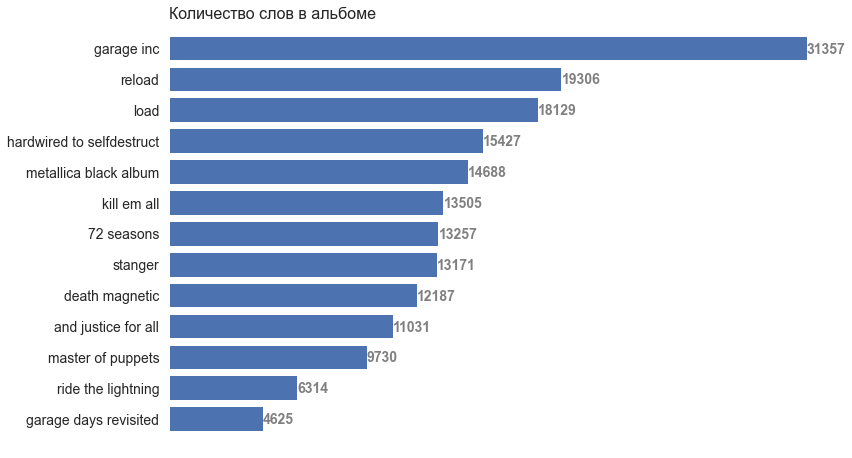

In [34]:
# построим диаграмму barh
sns.set_theme(style="whitegrid")
labels = count_word_df.index
data = count_word_df['word_count']
fig, ax = plt.subplots(figsize=(12,8))  
plt.barh(labels, data,  height=0.8, color='b') 
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.yticks(fontsize = 14)
plt.xticks([])
ax.set_title('Количество слов в альбоме',fontsize = 16,loc='left', y=0.98)
for i, v in enumerate(data):
    ax.text(v + 0.15 , i - 0.16 , str(v), color='grey', fontsize = 14, fontweight='bold')
plt.show()

Как видим из визуализации -  три из самых похожих альбома
(load, reload, garageinc) имеют наибольшее количество слов.

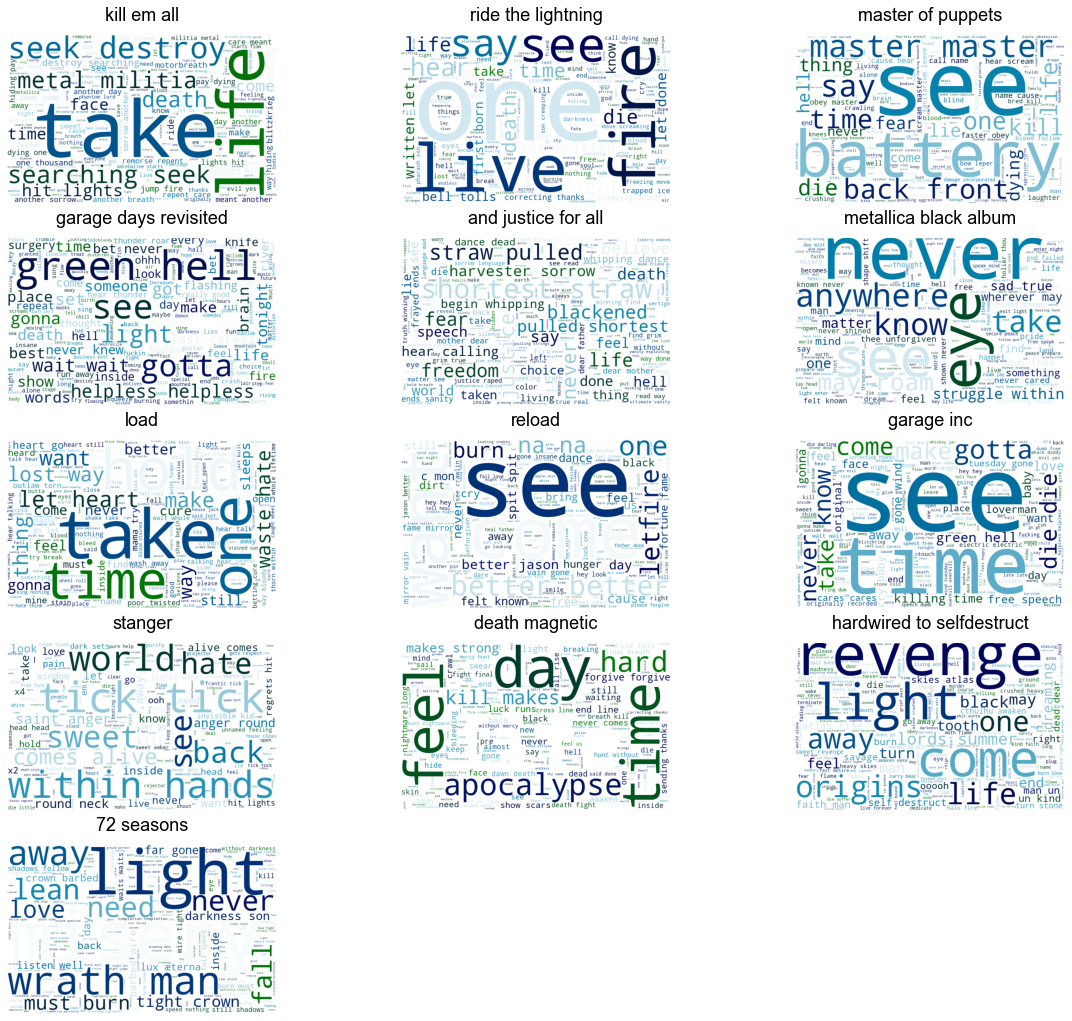

In [35]:
#### посторим облаков из слов по текстам каждого альбома Metallica:
i = 1
for name, text in zip(albums_clean, metallica_lemm_text_list):
    plt.rcParams['figure.figsize'] = (20,18)
    text_raw = " ".join(text)
    wordcloud = WordCloud(colormap='ocean_r', background_color='white',height =500, width = 800).generate(text_raw)
    plt.subplot(5, 3, i, label=name,frame_on=True)
    plt.tick_params(labelsize=10)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(name,fontdict={'fontsize':18,'color':'black'},y=1.05)
    plt.tick_params(labelsize=10)
    i += 1

## Выводы

В данном проекте на практике были применены основные методы NLP (за исключением stemming  - по причине построения облака слов).

Была применена модель  скрытого семантического индексирования текстов (LSI) - в результате чего был найден ряд интересных зависимостей.

Надеюсь мое исследование может быть полезно не только любителям хорошей музыки, но и более широкому  кругу пользователей.

## And Gensim for All...

P.S. Также очень хочется верить, что Ларс не засудит нас по авторским правам :)

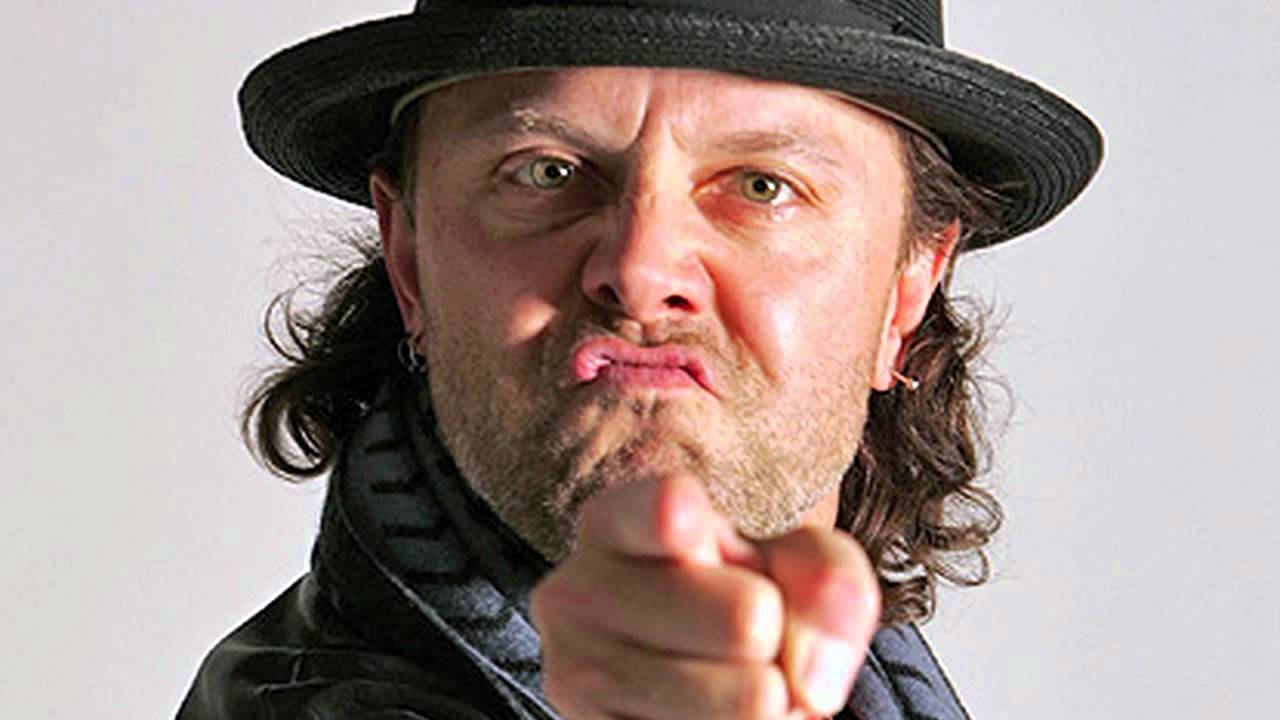

In [36]:
from IPython.display import Image
from IPython.core.display import HTML
Image(filename =  "maxresdefault.jpg", width=640, height=360)